In [ ]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit import quantum_info
from qiskit_aer import AerSimulator
from qiskit import transpile
from qiskit.circuit.classical import expr
from qiskit.circuit import Parameter
from qiskit.visualization import plot_histogram
from qiskit_ibm_runtime import SamplerV2 as Sampler

import matplotlib.pyplot as plt
import numpy as np

### Counting no of solutions for Groover operator.

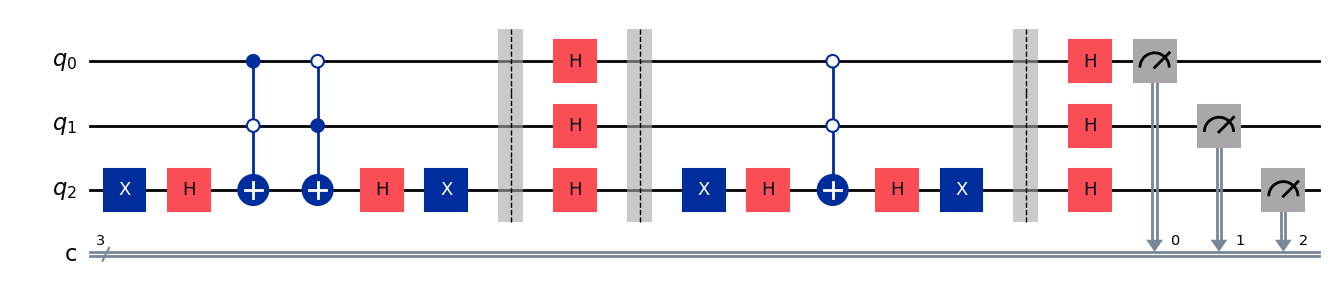

In [ ]:
def CG(control=True, gate=True, barrier=False, h=False, measure=False):
    # Groover operator that marks 001 and 010
    # 2 cubit circuit for verification
    if measure:
        circuit = QuantumCircuit(3, 3, name='G')
    else:
        circuit = QuantumCircuit(3, name='G')

    circuit.x(2)
    circuit.h(2)
    circuit.ccx(0, 1, 2, ctrl_state='01')
    circuit.ccx(0, 1, 2, ctrl_state='10')
    circuit.h(2)
    circuit.x(2)

    if barrier:
        circuit.barrier()

    circuit.h([0, 1, 2])
    
    if barrier:
        circuit.barrier()
    
    circuit.x(2)
    circuit.h(2)
    circuit.ccx(0, 1, 2, ctrl_state='00')
    
    circuit.h(2)
    circuit.x(2)

    if barrier:
        circuit.barrier()
    
    circuit.h([0, 1, 2])

    if gate:
        circuit = circuit.to_gate()

    if control:
        circuit = circuit.control()

    return circuit


g_circuit = CG(control=False, gate=False, barrier=True, h=True, measure=True)
g_circuit.measure([0,1,2],[0,1,2])
g_circuit.draw('mpl')

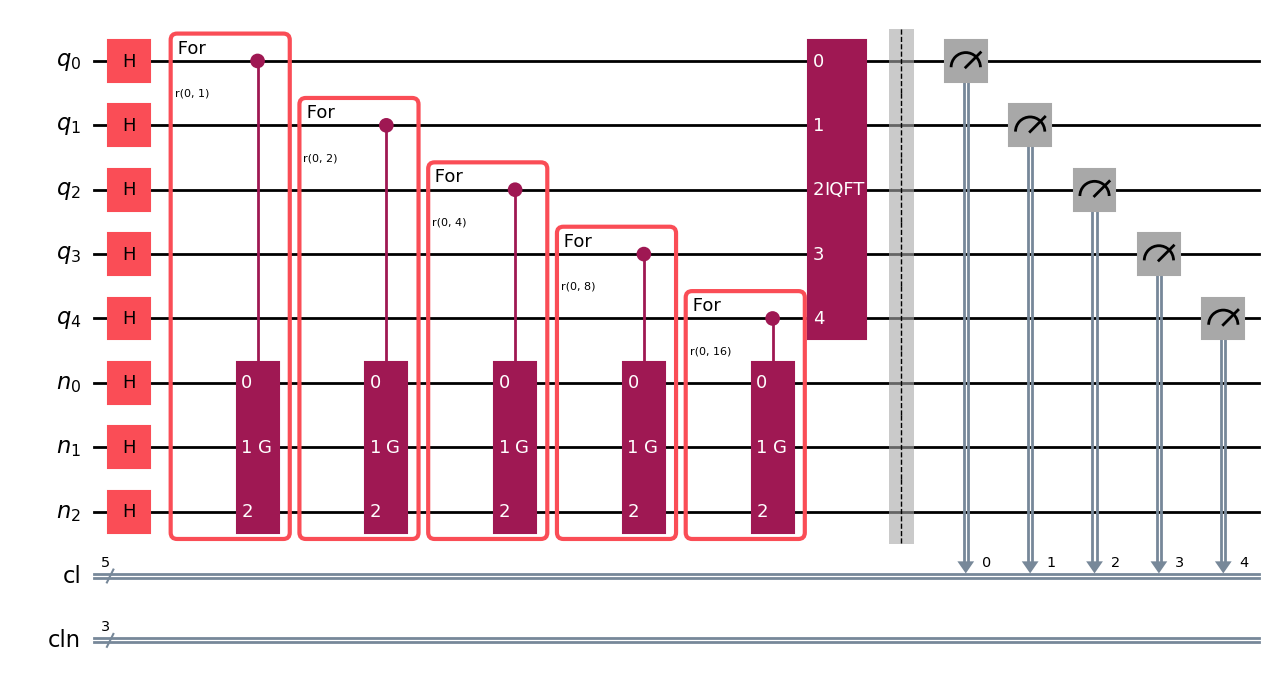

In [ ]:
from qiskit.circuit.library import QFT


def groover_count(c, n):
    # c = 5
    # n = 3

    quant_rg_c = QuantumRegister(c, 'q')
    quant_rg_n = QuantumRegister(n, 'n')
    class_rg = ClassicalRegister(c, 'cl')
    class_rg_n = ClassicalRegister(n, 'cln')

    cg = CG()

    circuit = QuantumCircuit(quant_rg_c, quant_rg_n, class_rg, class_rg_n)

    circuit.h([i for i in range(c)])
    circuit.h(list(range(c, c+n)))

    # QPE
    for q in range(c):
        exponent = 2**(q)
        with circuit.for_loop(range(exponent)) as i:
            circuit.append(cg, [q]+list(range(c, c+n)))

    circuit.append(QFT(c).inverse(), list(range(c)))

    circuit.barrier()
    circuit.measure(list(range(c)), list(range(c)))

    return circuit

groover_qpe = groover_count(5, 3)
groover_qpe.draw('mpl')

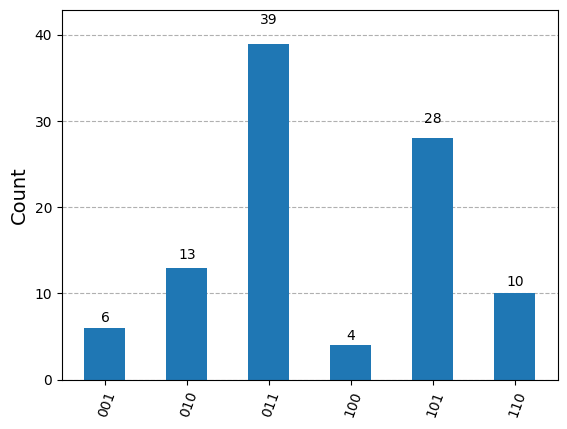

In [ ]:
from qiskit_aer import AerSimulator
from qiskit import transpile
from qiskit_ibm_runtime import SamplerV2 as Sampler

backend = AerSimulator(method='statevector')

c_list = [3,4,5,7]
stats_list = []
n = 3

for c in c_list:
    groover_qpe = groover_count(c, n)
    groover_qpe = transpile(groover_qpe, backend=backend)
    
    sampler = Sampler(backend=backend)
    result = sampler.run([groover_qpe], shots=100).result()
    stats = result[0].data.cl.get_counts()
    stats_list.append(stats)

plot_histogram(stats_list[0])

meu: 0.04
meu: 0.57
meu: 0.57
meu: 6.06


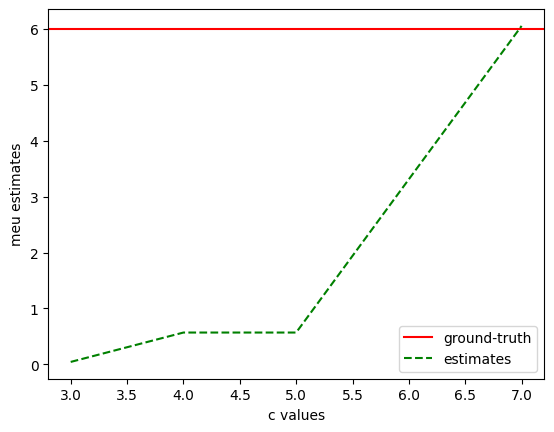

In [ ]:
def estimate_meu(stats, n):
    # For meu in groover operator
    phase_bits = max(stats, key=stats.get)

    phase = int(phase_bits, 2)
    theta = phase/(2**c)*np.pi

    meu = ((np.sin(theta))**2) * (2**(n))
    
    return meu


meu_list = []
for i in range(len(c_list)):
    stats = stats_list[i]

    meu = estimate_meu(stats, n)
    print(f'meu: {meu:.02f}')
    meu_list.append(meu)

plt.axline((3, 6), (c_list[-1], 6), color='r')
plt.plot(c_list, meu_list, 'g--')
plt.xlabel('c values')
plt.ylabel('meu estimates')
plt.legend(['ground-truth', 'estimates'])

plt.show()